In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#path = r'/home/schwartz/Documents/Schule/EML/'
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

# House Prices: Advanced Regression Techniques
### Joshua Schwartz, Marc Vidal, Michele Pariani, Turan Orujlu 

## Overview of the Competition
For our semester project, we decided to attempt **House Prices: Advanced Regression Techniques**, a competetion hosted by the website Kaggle (https://www.kaggle.com/c/house-prices-advanced-regression-techniques). The goal of this competition, as the name might suggest, was to predict prices for a test set of housing characteristics based on the provided training set of housing characteristics and associated house prices. In order to achieve this we would implement various techniques of feature engineering, random forests and gradient boosting. 
## The Data
The data consists of the Ames Housing Dataset, compiled by Dean De Cock (http://ww2.amstat.org/publications/jse/v19n3/decock.pdf), and was collected from neighborhoods of Ames, Iowa. This data set consists of 1,460 houses and their sale prices. Furthermore, a total of 79 features were selected (although certain features may be missing for particular houses). These features describe quantitatively and qualitatively many of the important physical attributes of the houses. Most of the variables selected answer many of the questions a potential home buyer might have while purchasing a house. That being said, this data set contains many features of a house which most likely would not be mentioned in the description of a 'dream-house' if described by the average person. However, subtle factors which inevitably contribute to the desirability of a house, e.g. ceiling height, or feet of street connected to the property must be factored into a machine learning algorithm if one wishes to accurately predict housing prices. 
### Sale Price
Here we show a histogram of the sale prices from the training set. 

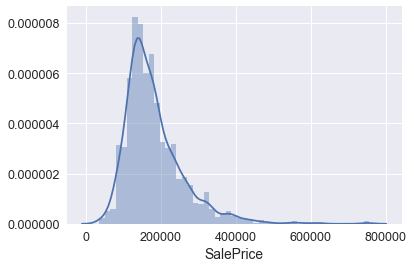

In [116]:
sns.distplot(df_train['SalePrice']);

Evidently, the housing sale prices are no normally distributed and tend to skew right. To correct fot this, we normalized it, using a log transform. Obviously we would like to determine which features of the data contributes most significantly to the sale price of the particular household. To understand this more clearly we will look at the relation of sale price to both categorical and numerical data. For obvious reasons we will not be able to go through every feature of the the data set, however, a full description of the Ames Data Set is provided here: https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt. 
### Categorical Data
Categorical data, for this data set, describes features which are of a qualitative or descriptive nature. For instance, in the categorical data we find features such as style of house, neighborhood, descriptions such as the general shape of the house. Of the 46 categorical features, 23 of them are nominal and 23 are ordinal. A nominal feature, for example, could be the type of road access to the property, which would be classified as either gravel or pavement. Ordinal categorical data differs importantly due to the fact that there is a clear ordering of the variables. Ratings of the overall condition of the house, for instance, range from *very good* to *very poor* in a 'continuous' manner. Below, an example plot of the feature *BsmtFinType 2* is shown in relation to housing sale price and is an description of the basement finished area. For the categories, *Unf* is unfinished, *BLQ* is below average living quarters, etc. As one might expect, *GLQ* (good living quarters) has the highest average in regards to sale price, but overall, this feature most likely not be the best predictor in comparison to other features.  

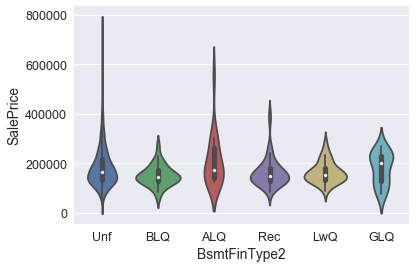

In [117]:
sns.violinplot(y='SalePrice', x='BsmtFinType2', data=df_train);

Observe, on the other hand, that overall quality of the houses seems to be an extremely helpfull feature in regards to housing price. In this case, 1 represents *very poor*, while 10 signifies *very excellent*. 

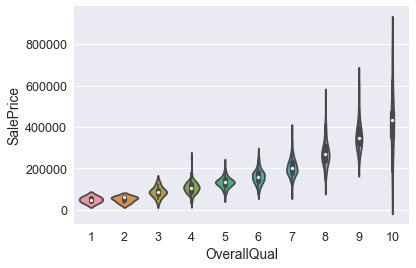

In [118]:
sns.violinplot(y='SalePrice', x='OverallQual', data=df_train);

### Numerical Data
For the Ames Data Set, the numerical data generally specifies values of spatial dimensions (e.g. height of basement and lot area) and features which are quantitative (e.g. number of bathrooms or kitchens) in nature. Of the 33 numerical features, 14 are discrete, while 19 are continuous. Discrete values would clearly be used for features such as number of cars which a garage may hold or even the number of bedrooms. Continuous values on the other hand are used to describe spatial dimensions, such as the areas of the house's garage, deck, porch, or pool. Later we will explore how particular discrete and continuous features may interrelate with one another in interesting ways. Below, the values for the general living area is plotted. This graph is interesting in a few ways. Firstly, and perhaps most notably, is the relatively clean linear relationship between the general living area and sale price. This will clearly be a helpful feature in the prediction of pricing. Next, is the fact that there appears to be two outliers which may reduce the quality of our predictions. In fact, when many other features are visualized, these two houses repeatedly show up as outliers. It can be reasoned that these properties, due to their large areas and low sale prices (in comparison) may be located in the outskirts of the city. 

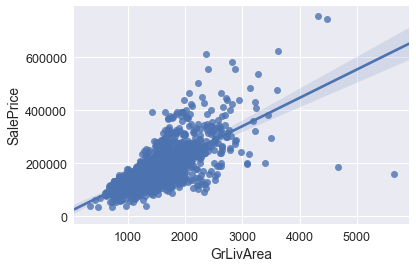

In [119]:
sns.regplot(x='GrLivArea', y="SalePrice", data=df_train);

In contrast, we see that features such as the finished basement's square footage (below), does not show any obvious correlation with sale price. 

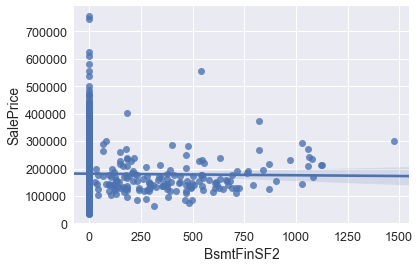

In [120]:
sns.regplot(x='BsmtFinSF2', y="SalePrice", data=df_train);

### Correlation Between Features
Undoubtedly, we wish to find which features correlate most strongly with sale price. In the heat map shown below, we see that factors such as overall quality, general living, and garage area are the most significantly correlated with sale price. It is important that we observe the particular features which are also interrelated. For instance, our eye will be drawn to the fact that garage area and the number of cars a garage can hold have a correlation of 0.88, which only makes sense. This, however, shows a certain level of redundancy in our data. Total rooms above ground and general living area are also highly correlated (0.83). Again, one could say that this is more of less logically necessary. Lastly, 1st floor surface area and total basement surface area have a correlation of 0.82.

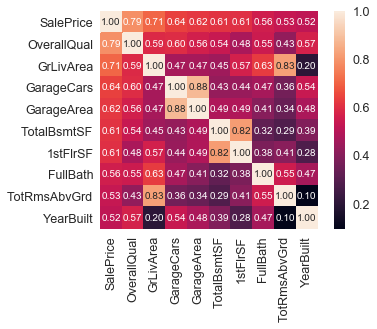

In [121]:
cor = df_train.corr()
k = 10
cols = cor.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
map = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Missing data
### Pandas' NA assumption
As we already mentioned above, we used the Python Library Pandas to automatically load our dataset into data frames and work with it. While doing this, and by not paying enough attention to the dataset description at the very first place, naively we had many missing values.

The next tables show the missing values in total number and percentage on both sets. The left table represents the training set whereas the right one describes the testing set.

In [122]:
# TRAIN
total_train = df_train.isnull().sum()
percent_train = total_train / len(df_train)
missing_train = pd.concat([total_train, percent_train], axis=1, keys=['Total', 'Percent'])
missing_train = missing_train[missing_train['Total'] != 0].sort_values(by='Total', ascending=False)
# TEST
total_test = df_test.isnull().sum()
percent_test = total_test / len(df_test)
missing_test = pd.concat([total_test, percent_test], axis=1, keys=['Total', 'Percent'])
missing_test = missing_test[missing_test['Total'] != 0].sort_values(by='Total', ascending=False)
display(missing_train, missing_test)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


,Total,Percent
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageCond,78,0.053461
GarageYrBlt,78,0.053461
GarageQual,78,0.053461
GarageFinish,78,0.053461


As it can be easily noticed from the previous numbers, some of the features seemed to have more than its half of values missing. The reason behind it is that Pandas by default encodes the string value "NA" as a missing value. But, after reading carefully the features description of the dataset we noticed that "NA" had actually a meaning. Precisely, in most of the cases "NA" stands for a lack of the given feature. Thus, it does not represent a missing value at all. For instance, in case of Garage variables it means a lack of garage, in case of Pool ones a lack of pool, in case of MiscFeature a lack of a miscellaneous feature, and so on.

### Our assumptions
After identifying this issue, the amount of missing values dropped down up to almost nothing, but for features such as LotFrontage, for instance. In this case, we have more than 15% of missing data in both training and testing sets. And, although we do not know for sure if "NA" stands for a missing value, due to it is not mentioned on the features description, we assumed "NA" means there is no "linear feet of street connected to property" (variable description). Thus, we replaced all NAs with 0. 

Another interesting case to comment is the variable "PoolQC". Although apparently 99,5% of the data is missing, due to Pandas' NA interpretation. So, in fact, meaning no pool in most of the cases, we filled these values with the label "None" where the related feature PoolArea was 0, whereas we used "TA" (the mode of this feature) when the latter was not 0, to fill up the exceptions found. 

## Preprocessing
As mentioned above using examples, we replaced the label "NA" for "None" in case of a lack of the feature, but for the cases we identified it was a real missing value. And, since the cases we identified belong mostly to categorical features, we replaced the missing values by the mode, so the most used label within the feature labels. 
E.g.:

"NA" replaced for "None":
$$ dataset["Fence"].fillna("None", inplace=True) $$
Missing value replaced for the mode: 
$$ dataset["Electrical"].fillna("SBrkr", inplace=True) $$ 

Apart from this procedure, in our preprocessing function we implemented as well feature engineering, feature scaling (standarization and normalization) and one-hot vectors (also known as dummy variables).

### Feature engineering
By applying feature engineering, we understand the process of transforming raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data (Browniee, 2014). 

Bearing this idea in mind, we created a total of 10 new binary variables while comparing information between the given features. For instance, we introduced the feature "Remodeled" setting it to 1 if "YearRemodAdd" != "YearBuilt", and so to 0 if it was not fullfilled:

$$ dataset["Remodeled"] = (dataset["YearRemodAdd"] != dataset["YearBuilt"]) * 1 $$

Another example, we added the feature "IsLandLevel" by checking if the label in "LandContour" was "Lvl". Thus, setting it to 1 if this condition was fullfilled, and to 0 if not:
$$ dataset["IsLandLevel"] = (dataset["LandContour"] == "Lvl") * 1 $$


### Feature scaling
We plotted histograms for all numerical features, hence excluding the ordinal and categorical ones. And we checked for the skewness, which essentially tells us how symmetric a distribution is by measuring the relative size of the two tails. The results told us that most of the distributions are not symmetric. Following this idea, we decided to log transform all distributions with a skew value bigger than 3, in this way we made the required variables become normally distributed (or close to normal). Thus, it helped us better modeling the relationship between the target and the independent variables. 

The next images are two graphs extracted from our presentation slides where the probability density of the feature "LotArea" is plotted before and after applying the log transform function after evaluating its skewness.
<img src="before-after.png">
After normalizing our data, we had to deal with outliers. In order to achieve this, we standardized the continuous train features. We know that standardization is a common approach to feature scaling and is practical for many machine learning algorithms, because many linear models initialize the weights to 0 or small random values close to 0. And moreover, using standardization, we center the feature columns at mean 0 with standard deviation 1, which makes it easier to learn the weights (Raschka, 2016). Our primarily assumption was to consider outliers where the standardized values where bigger than three times the standard deviation. However, examples (Id) 524 and 1299 appear multiple times as outliers. We drop them from the training data during preprocessing. Examples 1183 and 692 appear multiple times as well, but we leave them in the training set because our model performs worse if they are removed.


### Dummy variables
The last step in our preprocessing function was the implementation of one-hot vectors, also known as dummy variables. One-hot encoding transforms categorical features to a format that works better with classification and regression algorithms (Quora, 2016).

(The image here below is taken from Quora, 2016.)
<img src="hot-vector.png">

So, as the above definition explains, and as the image displays, what we basically did was to encode our categorical features as simple binary variables. In this same way, a hypothetically categorical variable named "Color", containing the labels "Red", "Green" and "Blue", would be encoded as next. Per each label a new binary feature would be added, which would contain 1 or 0 by meaning red or no red, green or no green, and blue or no blue, respectively. We implemented this idea in our dataset by using Pandas’ method "get_dummies".


## Test different models
After data preprocessing, we tried out different models. We picked three linear models (Ridge, Lasso and Elastic Net), and two ensemble models (Random forest regressor and Gradient boosting regressor). Before giving a brief introduction of how the models work, I will explain which scoring function and which technique we used to measure predictive performance.

### R-squared
The scoring function we used is R-squared and it is defined as:

$$ R^2 = 1 - \frac{SSres}{SStot} = 1 - \frac{\sum\limits_{i} (y_i - \hat{y}_{i})^2}{\sum\limits_{i} (y_i - \bar{y}_{i})^2} $$

where *SSres* indicates the residual sum of squares and *SStot* indicates the total variation in the response variable. The higher R-squared, the better the model fits the data, i.e., if the regression line is a good fit, *SSres* will be very small and, thus, R-squared will be close to 1.

### K-fold cross-validation
Cross-validation is a technique to measure predictive performance of a model, i.e., estimate the prediction error. In K-fold cross-validation, the training set is split into *k* folds without replacement, i.e., each example will be part of exactly one fold. *k-1* folds are used for training and the remaining fold is used for testing. This procedure is repeated for *k* iterations. Thus, we obtain *k* models and performance estimates.
The estimated average performance *E* of a model is defined as: $$ E = \frac{1}{K} \sum\limits_{i=1}^k E_k $$
(The image here below is taken from Raschka, 2016.)
<img src="k-fold.png">



### Regularized linear models
Ridge regression, Lasso regression and Elastic Net work by penalizing the magnitude of features' coefficients.
This is necessary because the size of coefficients increases exponentially with increase in model complexity. Thus, we put a constraint on the magnitude of coefficients.
#### Ridge
Ridge regression performs ‘L2 regularization‘, i.e. it adds a factor of sum of squares of coefficients in the optimization objective. 

$$ J(w)_{Ridge} = \sum\limits_{i=1}^n (y^{(i)} - \hat{y}^{(i)})^2 + \lambda \sum\limits_{j=1}^m w_j^2 $$

Lambda is the parameter that balances the degree of regularization. If lambda=0, the objective becomes the same as unregularized linear regression, whereas if lambda=$\infty$, the coefficients will be zero (i.e., high alpha values can lead to significant underfitting, because the model complexity reduces as the value of lambda increases). Thus, lambda needs to be positive but small enough to create a model complex enough to fit the dataset. One of the most common ways to choose lambda is cross-validation. The class RidgeCV in sklearn offers built-in cross-validation. The most important characteristic of Ridge regression is that it makes the coefficients very very small, but they are not zero. This happens because ridge regression is equivalent to reducing the weight by a factor of (1-2λη) first and then applying the same update rule as unregularized linear regression (using gradient descent). Although Ridge is a continuous shrinkage method, it cannot produce a parsimonious model, because it always keep all the features in the model.
#### Lasso (Least Absolute Shrinkage and Selection Operator)
Lasso regression performs L1 regularization, i.e. it adds a factor of sum of absolute value of coefficients in the optimization objective.

$$ J(w)_{Lasso} = \sum\limits_{i=1}^n (y^{(i)} - \hat{y}^{(i)})^2 + \lambda \sum\limits_{j=1}^m | w_j | $$

Due to the nature of L1 penalty, Lasso carries on continuous shrinkage and automatic variable selection simultaneously. Automatic variable selection happens because the absolute value function is not differentiable at zero. Thus, we cannot use gradient descent here. Instead, Lasso uses coordinate descent (not discussed in detail here). What is important to understand is why the Lasso coefficients become zero in the range $ [- \frac{\lambda}{2}, \frac{\lambda}{2}] $. This has to do with the update rule of coordinate descent: if the difference between actual outcome and predicted outcome, calculated considering all the features but the $ j^{th} $ one, is small then this means that the algorithm can predict the result pretty well without the $ j^{th} $ feature and therefore we can remove it from the equation by setting its coefficient to zero. Moreover, the coefficients are reduced by a constant factor (with Ridge, coefficients are a reduced factor of the simple linear regression coefficients). However, one of the biggest limitations of Lasso is that it tends to randomly select only one variable from a group of variables among which the pairwise correlations are very high. 
#### Elastic Net
Elastic net is a regularization technique that fixes the limitations of Lasso. It linearly combines the L1 and L2 penalties of Lasso and Ridge regression.

$$ J(w)_{ElasticNet} = \sum\limits_{i=1}^n (y^{(i)} - \hat{y}^{(i)})^2 + \lambda_2 \sum\limits_{j=1}^m w_j^2 + \lambda_1 \sum\limits_{j=1}^m | w_j | $$

A desidered feature for a regression method (that Lasso does not have - see last sentence in the previous sub-chapter) is the grouping effect. The grouping effect is present if the regression coefficients of a group of highly correlated variables tend to be equal. Because the penalty function of elastic net is stricly convex, i.e., its second derivative is bigger than zero, and strict convexity guarantees the grouping effect, the elastic net regression model enjoys the grouping effect. For this reason, elastic net performs better than Lasso in those situations where the grouping effect is required (e.g., when the number of predictors is bigger than the number of examples).

    
### Ensemble methods
#### Random Forests
Each tree in the ensemble is built on a sample drawn with replacement from the training set, i.e., we randomly sample the rows of the training data with replacement. In addition, when splitting a node during the construction of the tree, the split that is chosen is the best split among a random subset of the features. As a result of this randomness, the bias of the forest usually slightly increases but, due to averaging, its variance also decreases, usually more than compensating for the increase in bias.
#### Gradient boosting
Gradient boosting implementations usually initiliaze the model with a single prediction value (e.g., the mean of the training target values). At the first iteration, the gradient is computed with respect to the single prediction value. Then we fit a regression tree to the gradient components. The leaf nodes of the tree produce an average gradient among examples with similar features. For each leaf, we step in the direction of the average gradient. We repeat this process until convergence. The step magnitude of gradient descent can be adapted by line search, instead of providing a fixed magnitude for each step.


## Tuning of hyperparameters
In order to tune the hyperparameters, we used GridSearch, a brute-force exhaustive search paradigm. Here below we list which parameters we tuned for each model:
- LassoCV: we tuned eps (i.e., alpha_min/alpha_max) and n_alphas (i.e., number of alphas along the regularization path). The best model is selected by cross-validation (built-in in sklearn).
- RidgeCV: default parameters return the best performance for this model (cross-validation built-in).
- ElasticNetCV: we tuned eps (i.e., alpha_min/alpha_max) and l1_ratio (i.e., it scales between L1 and L2 penalties, where values close to 0 make the model behave more like Ridge, whereas values close to 1 make the model behave more like Lasso). Cross-validation is built-in.
- Random forest regressor: we tuned max_depth (i.e., how deep a single tree can get) and number of estimators (i.e., how many trees in a forest).
- Gradient boosting regressor: we tuned max_depth, number of estimators and the learning rate (i.e., it shrinks the contribution of each tree).

## Addendum: Alternative preprocessing method for missing values

As mentioned above, even after taking into account that certain 'NA' values should be interpreted as 'None' according to data description, some variables still had missing values (in the case of 'LotFrontage', there were a few hundred missing values). Besides assigning zeros and 'None's to them, we tried another approach when it comes to dealing with missing values.

The idea was to predict missing values by running regression for continous variables, and classification for discrete numerical or categorical ones. We separated the variables with missing values and without missing values into distinct data sets. We called the data set with variables that have no missing values the complete data set, and the one containing variables with missing values, the incomplete data set. We treated the complete data set variables as predictors.

To effectively use the available information, variables in the incomplete data set was sorted from the ones with fewest missing variables to most. We treated each variable in the incomplete data set as a regression or classification target. For each variable, missing values and non-missing values were separated into training and "testing" batches respectively. Complete data was also split into training and "testing" batches accordingly. Classifications/regressions were run on training data using the complete data as predictor and incomplete data variable as predicted variable. Then the trained model was used to assign values to the "testing" batch. After filling in the missing values, the target variable was attached to the complete data and the whole process was repeated until there were no variables left in the incomplete data set.

To our surprise, the new method did not improve the naive approach of assigning 'None', 0, or the mode of the variable to the missing values that we had employed before. You can see the results in the tables below:

                                                             
$$Naive\,Approach$$                                            
 
| Regression Method | Training accuracy | Validation accuracy | 
|-------------------|-------------------|---------------------|
| LassoCV           | 0.921             | 0.912               | 
| RidgeCV           | 0.918             | 0.908               |
| Random Forest     | 0.880             | 0.862               |
| Gradient Boosting | 0.908             | 0.899               |
| Elastic Net       | 0.921             | 0.912               | 

$$New\,Method$$

| Regression Method | Training accuracy | Validation accuracy |
|-------------------|-------------------|---------------------|
| LassoCV           | 0.899             | 0.884               |
| RidgeCV           | 0.903             | 0.885               |
| Random Forest     | 0.884             | 0.861               |
| Gradient Boosting | 0.909             | 0.896               |
| Elastic Net       | 0.898             | 0.890               |

Note: The code for the addendum part is separate from the main code.

## References

Browniee, J. (2014, September 26). Discover Feature Engineering, How to Engineer Features and How to Get Good at It. Retrieved from http://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/

Quora (2016, December 20). What is one hot encoding and when is it used in data science?. Retrieved from https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science

Raschka, Sebastian (2016). Python Machine Learning. Packt Publishing, Birmingham.

Zou, Hui, and Hastie, Trevor (2005). Regularization and variable selection via the elastic net. J. R. Statist. Soc. B, 67, Part 2, pp. 301–320.